In [83]:
import colorthief as ct
import requests
from io import BytesIO
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [4]:
# Grab the data from the boardgame geek website
url = 'https://boardgamegeek.com/browse/boardgame'
response = requests.get(url)    

In [5]:
soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('td')  if 'collection_thumbnail' in x['class']]

In [8]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [9]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

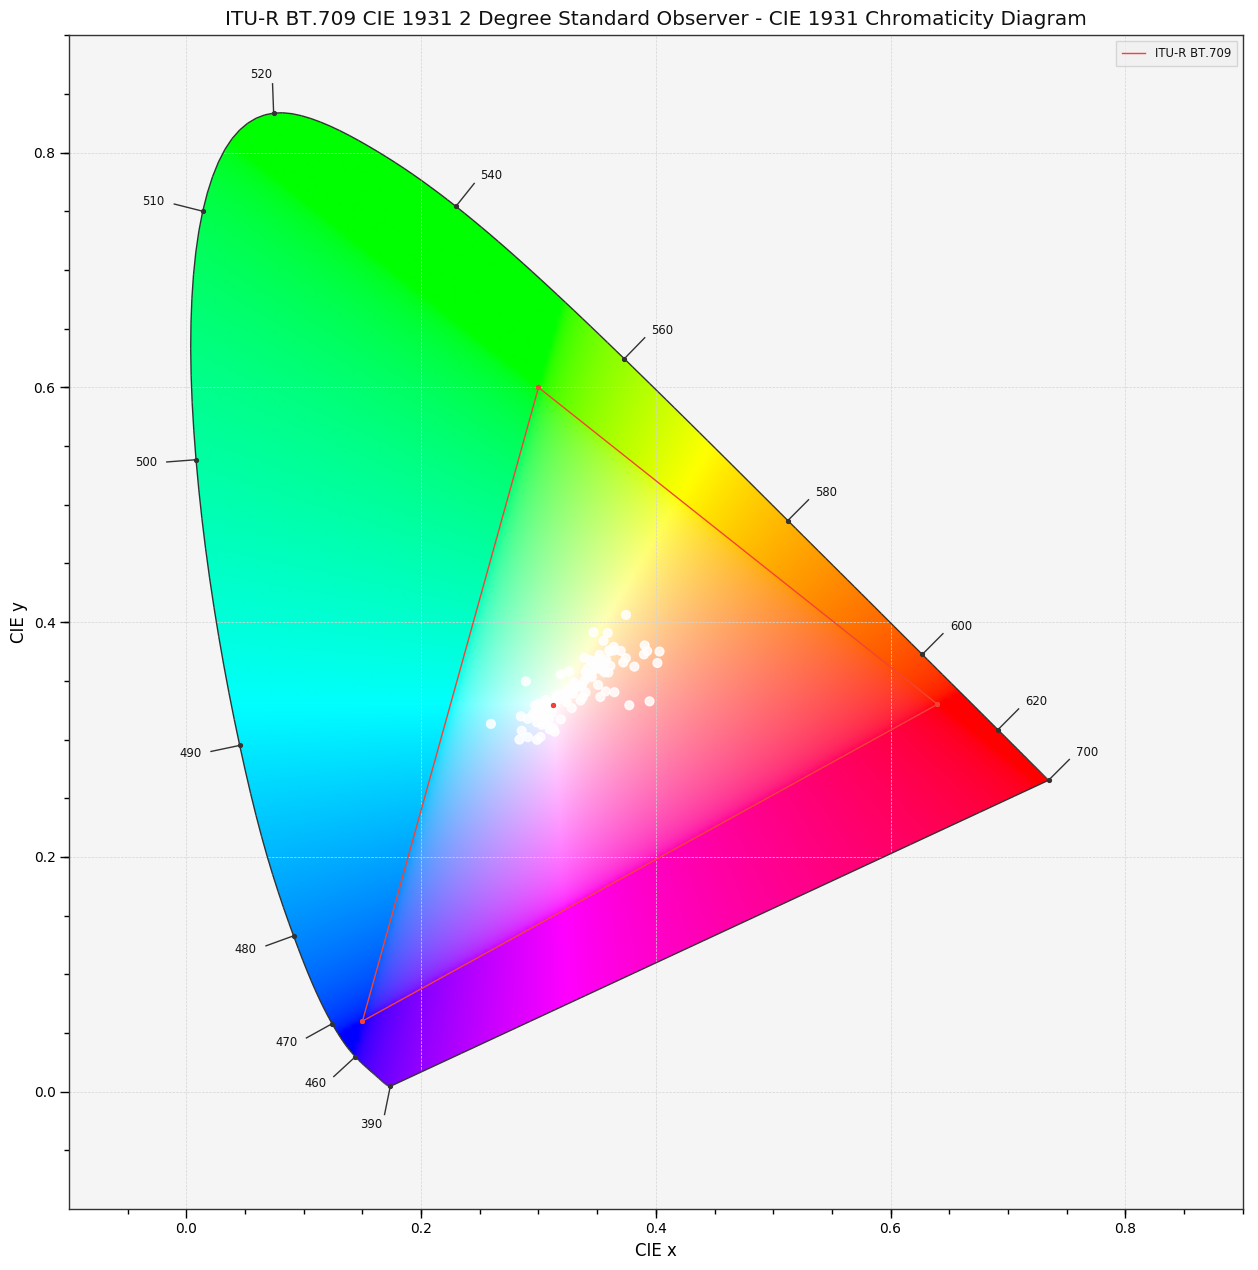

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef5fb8cd30>)

In [23]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    [RGB], 'ITU-R BT.709')

In [11]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6) for x in colour_thief]

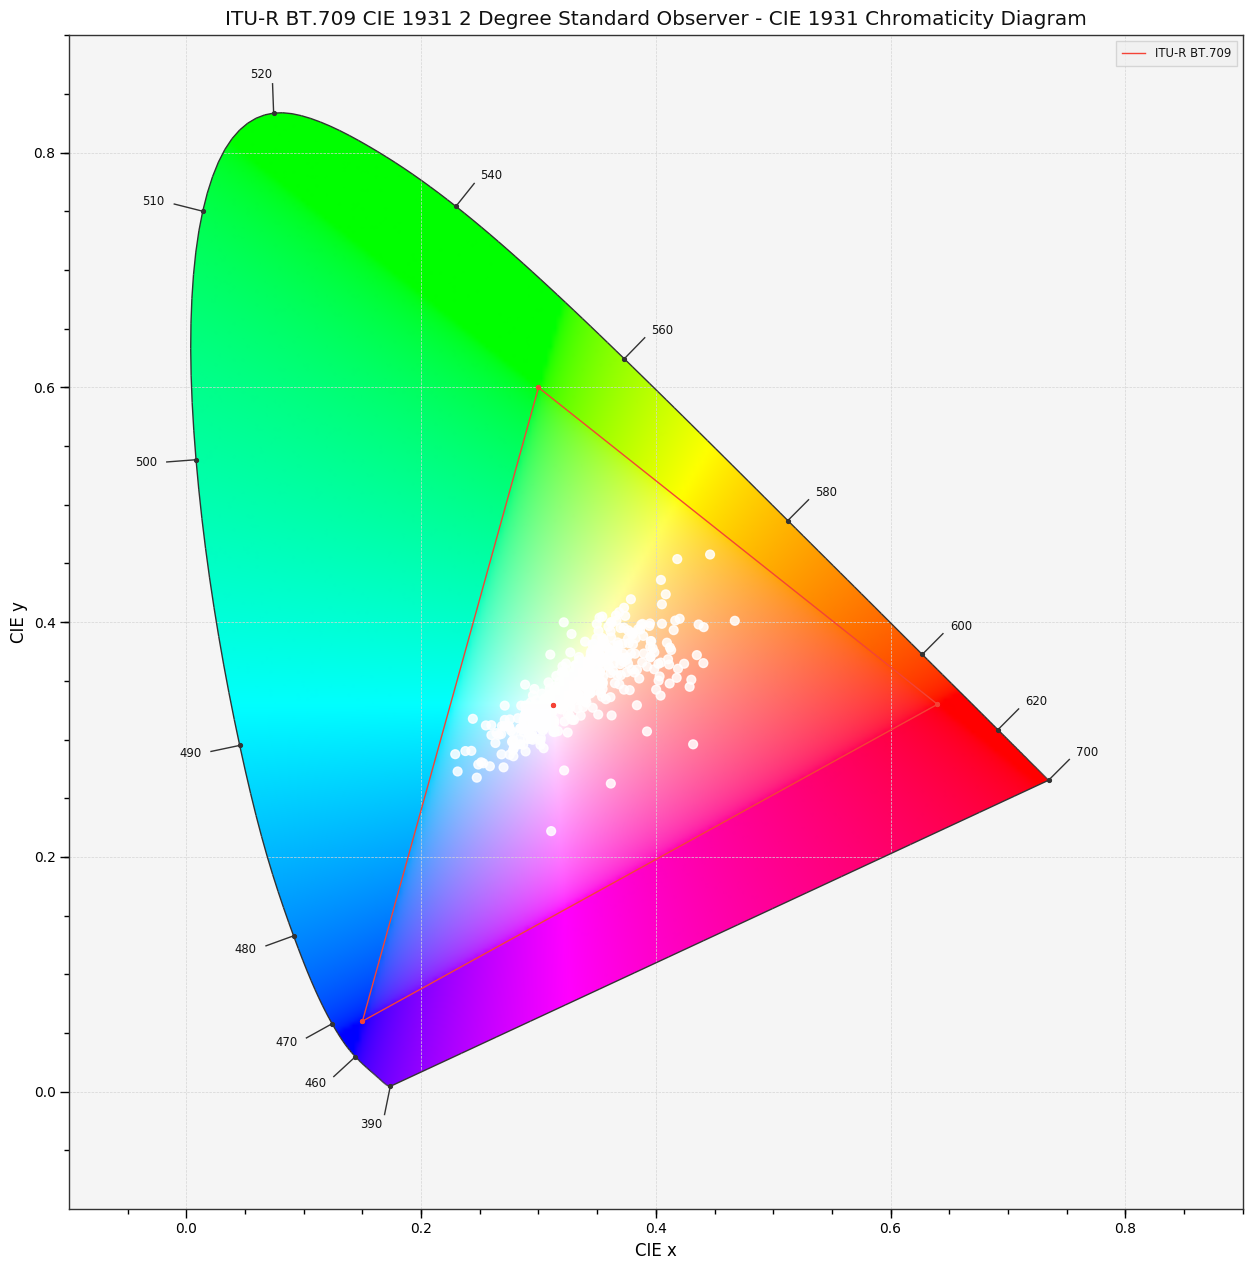

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef6258b7f0>)

In [48]:
# And plot them in the same way
RGBP = np.array(palette)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGBP, 'ITU-R BT.709')

In [13]:
# Grab the data from the Amazon.co.uk 
url = 'https://www.amazon.co.uk/Best-Sellers-Toys-Games-Board/zgbs/kids/364146031'
response = requests.get(url)    
soup = BeautifulSoup(response.text, 'html.parser')

In [41]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('li')  if x.has_attr('class') and 'zg-item-immersion' in x['class']]

In [45]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [46]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

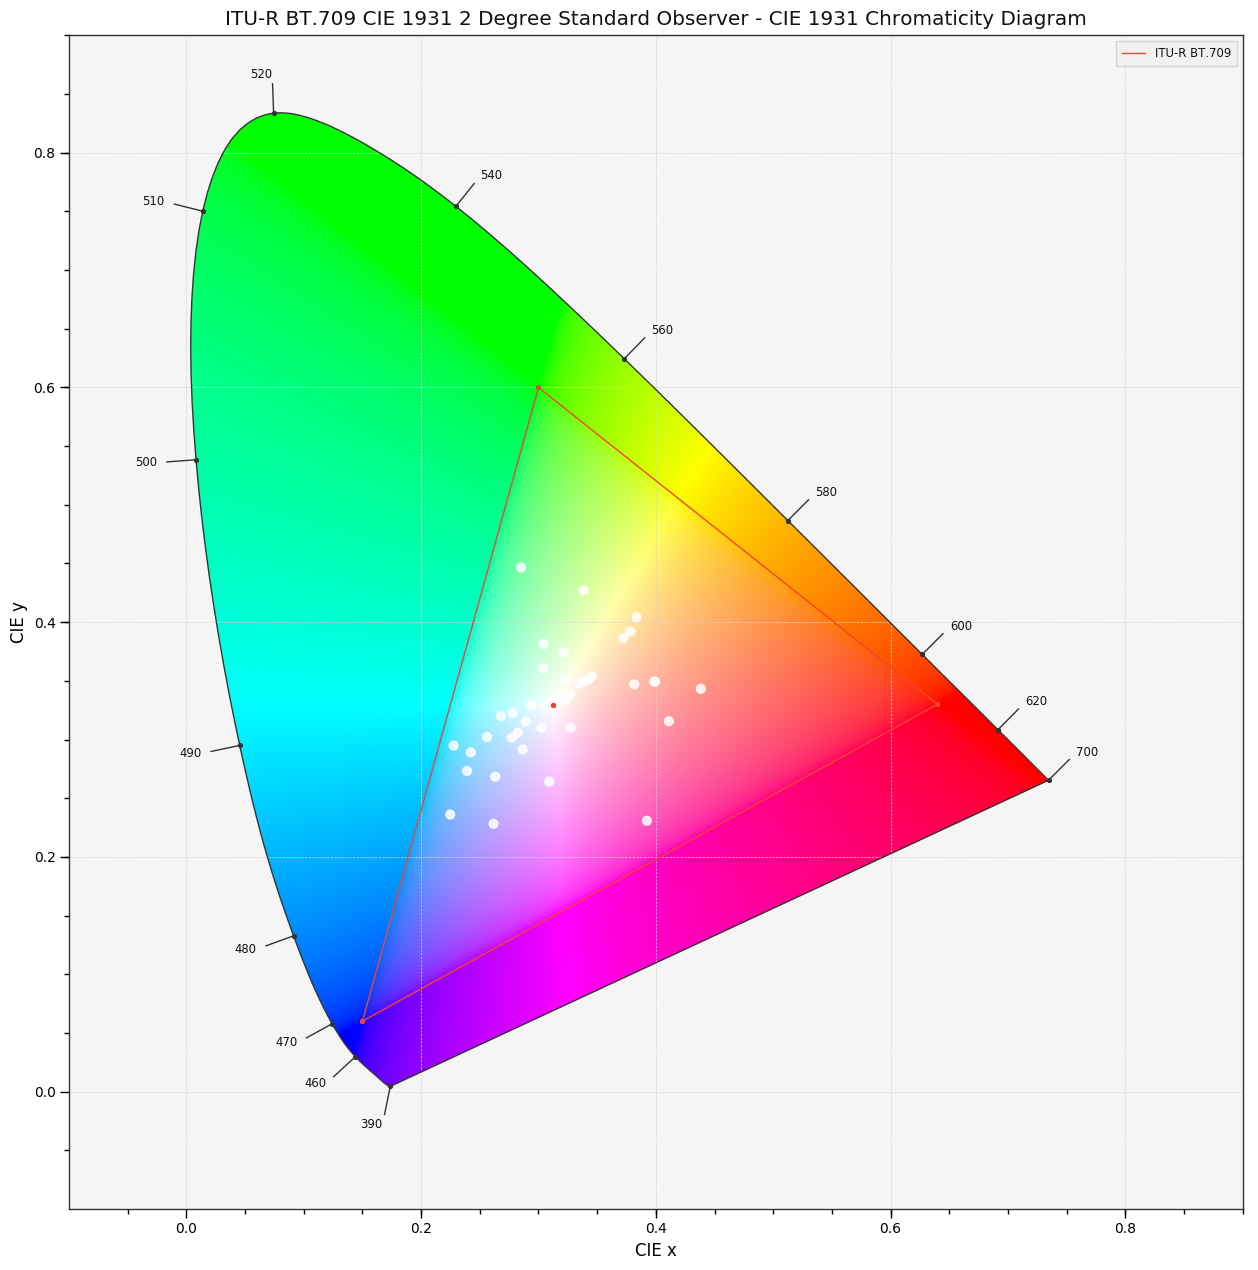

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef5503dac8>)

In [47]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    [RGB], 'ITU-R BT.709')

In [49]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6) for x in colour_thief]

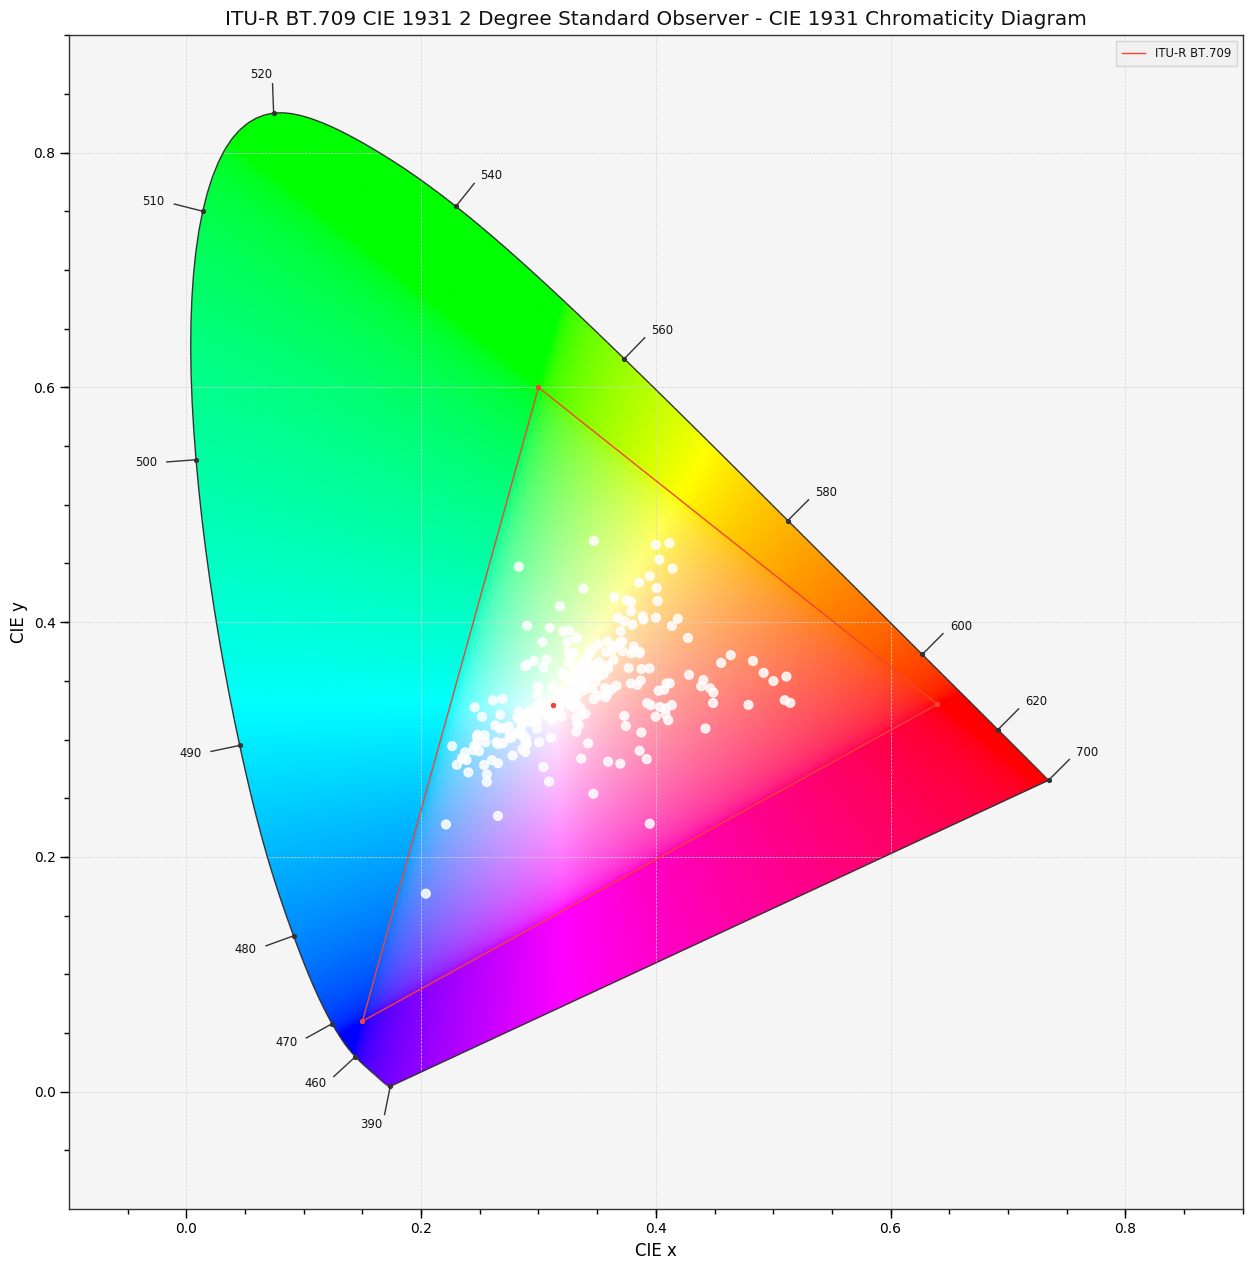

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef646235c0>)

In [50]:
# And plot them in the same way
RGBP = np.array(palette)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGBP, 'ITU-R BT.709')

In [51]:
# Grab the data from the Amazon.co.uk 
url = 'https://www.amazon.com/Best-Sellers-Toys-Games-Board/zgbs/toys-and-games/166225011'
response = requests.get(url)    
soup = BeautifulSoup(response.text, 'html.parser')

In [52]:
# Get all the thumbnail images from the games
thumb = [x.findAll('img')[0]['src'] for x in soup.findAll('li')  if x.has_attr('class') and 'zg-item-immersion' in x['class']]

In [53]:
# Get the colour information from them
colour_thief = [ct.ColorThief(BytesIO(requests.get(x).content)) for x in thumb]

In [54]:
# Get all the dominant colours
dominant = [x.get_color(quality=1) for x in colour_thief]

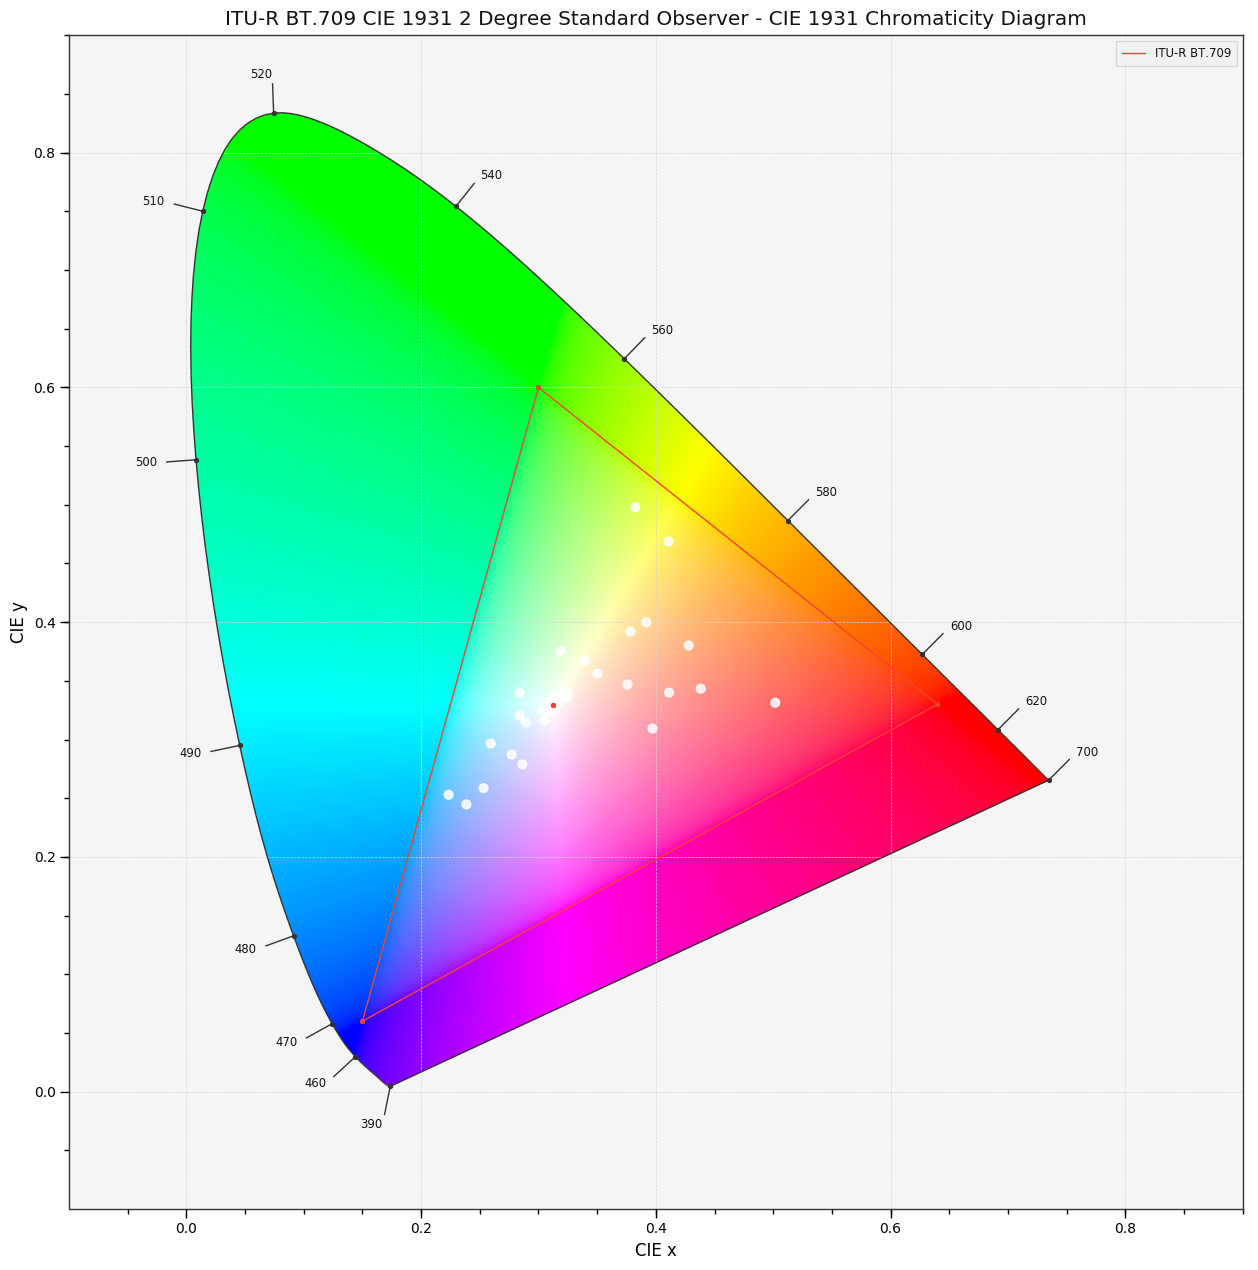

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef6251c3c8>)

In [55]:
# Plot the dominant colours on the funky colour thingy which lets you display RGB in 2D
import numpy as np
RGB = np.array(dominant)
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, colour_style
colour_style()
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    [RGB], 'ITU-R BT.709')

In [56]:
# get the 6 representative palette colours
palette = [x.get_palette(color_count=6) for x in colour_thief]

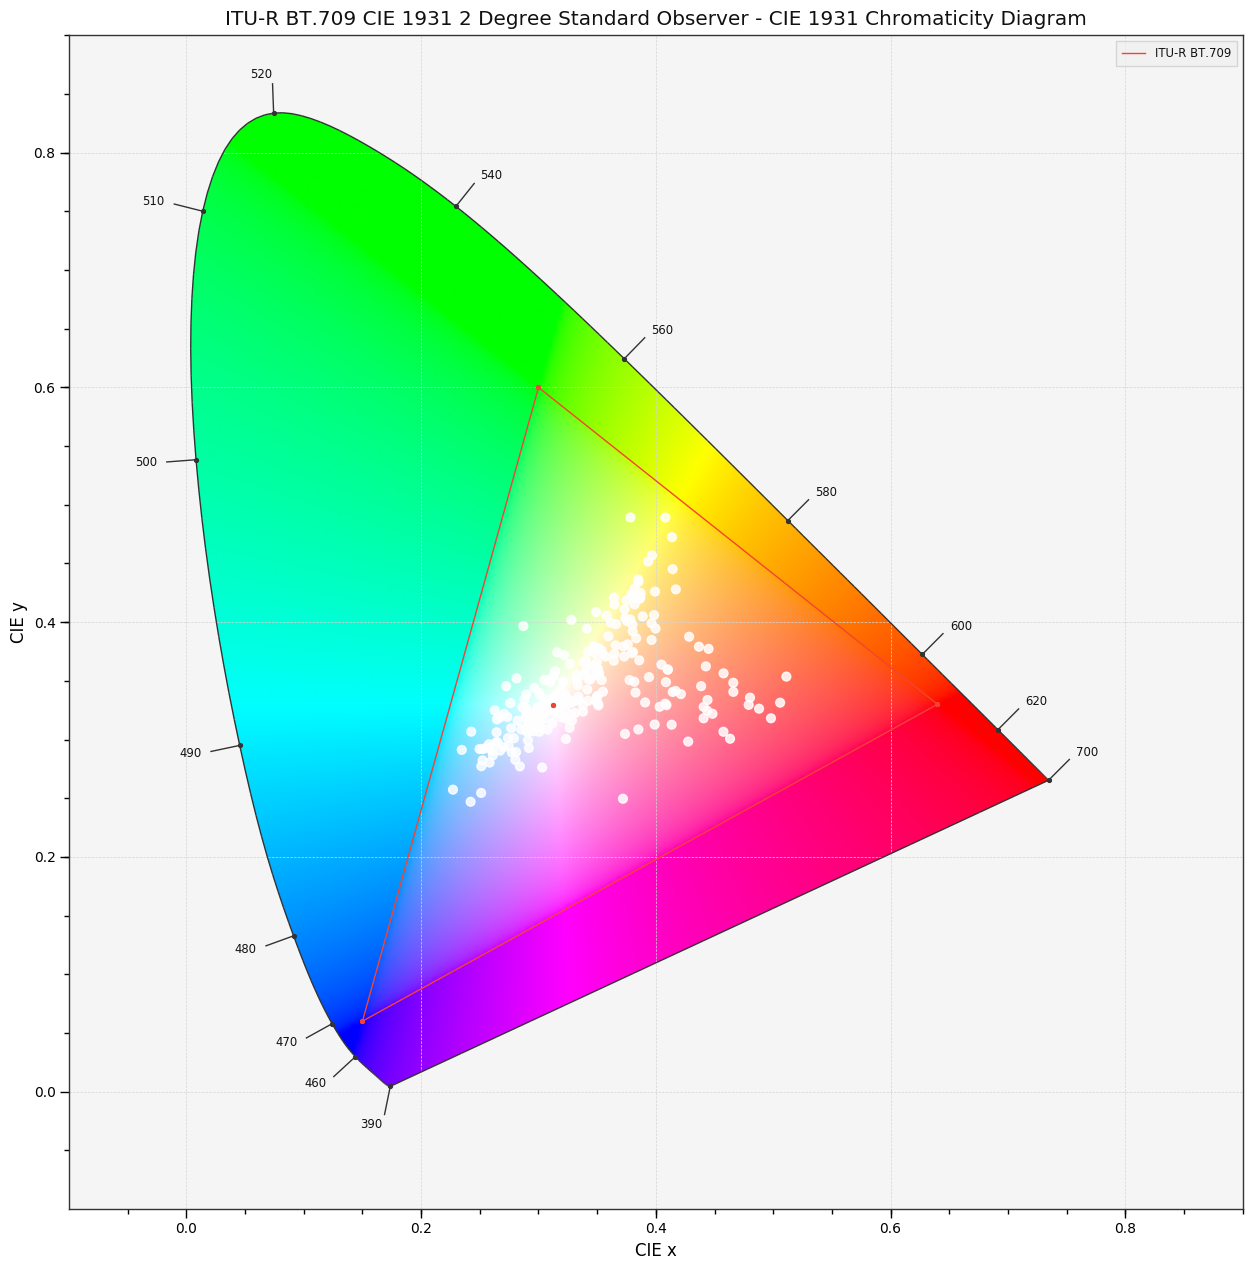

(<Figure size 1280x1280 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef6462e668>)

In [57]:
# And plot them in the same way
RGBP = np.array(palette)
plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(
    RGBP, 'ITU-R BT.709')

In [71]:
histR,bins = np.histogram(RGB[:,0],bins = [0,25,50,75,100,125,150,175,200,225,250])
histG,bins = np.histogram(RGB[:,1],bins = [0,25,50,75,100,125,150,175,200,225,250])
histB,bins = np.histogram(RGB[:,2],bins = [0,25,50,75,100,125,150,175,200,225,250])

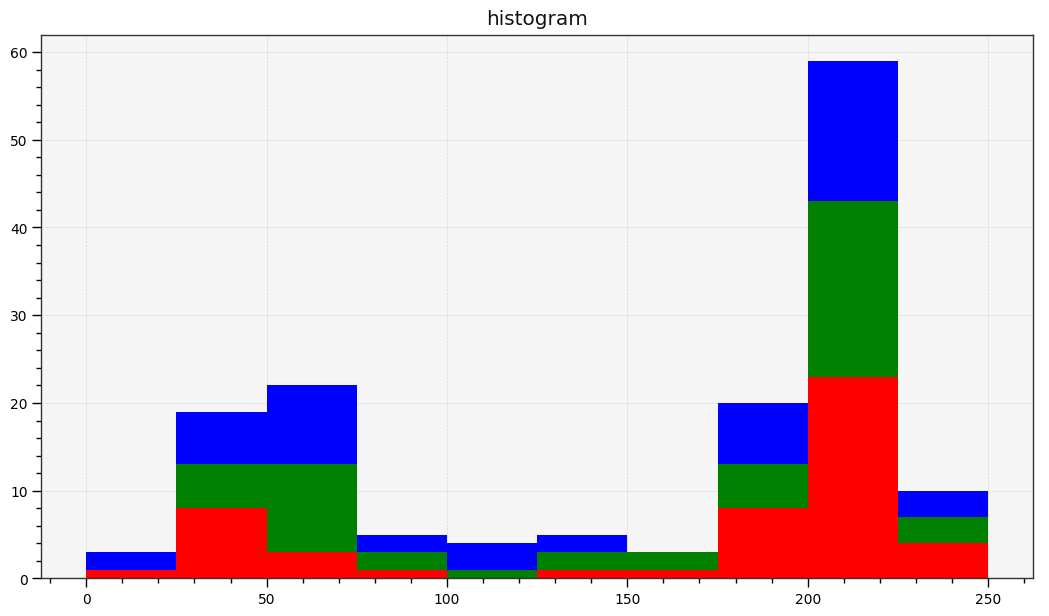

In [79]:
from matplotlib import pyplot as plt 

plt.hist(RGB, bins = [0,25,50,75,100,125,150,175,200,225,250], histtype='barstacked', color=('r', 'g', 'b')) 
plt.title("histogram") 
plt.show()

In [68]:
bins

array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250])

In [84]:
ctd = ct.ColorThief('./DarkBox.png')
ctl = ct.ColorThief('./LightBox.png')

In [85]:
ctd.get_color(quality=1)

(13, 21, 55)

In [86]:
ctl.get_color(quality=1)

(211, 229, 233)